In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks import *
torch.cuda.set_device(1)
from fastai.vision.interpret import SegmentationInterpretation

In [5]:
train_img = './basic/train/imgs'
train_mask = './basic/train/masks'
codes = ['road','background']
img_size = 1024
bs = 1
wd=1e-2

In [6]:
get_y_fn = lambda x: train_mask+f'/{x.stem}{x.suffix}'
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [9]:
src = (SegItemListCustom.from_folder(train_img).split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=img_size, tfm_y=True).databunch(bs=bs).normalize())
data.show_batch(2, figsize=(10,7))

In [7]:
def accuracy(input_img, target):
    target = target.squeeze(1)
    return (input_img.argmax(dim=1)==target).float().mean()

def iou(input_img, target):
    return dice(input_img, target, iou=True)

In [ ]:
learn = unet_learner(data, models.resnet101, metrics=[accuracy], wd=wd,self_attention=True)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(1e-06,1e-03),callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='res101-sattelite-naive-stage1'),CSVLogger(learn,filename='res101-sattelite-naive-stage1',append=True)])


In [ ]:
learn.load('res101-sattelite-naive-stage1_9')

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(5e-5,8e-4),callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='res101-sattelite-naive-stage2'),CSVLogger(learn,filename='res101-sattelite-naive-stage2',append=True)])

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.validate(metrics= [acc,iou])

In [ ]:
interpret = SegmentationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)
mean_cm, single_img_cm = interpret._generate_confusion()
mean_cm

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean pixel error")

## Test Results

In [10]:
test_folder = './test/imgs/'
get_lbl_test = lambda x: './test/mask/'+f'/{x.stem}{x.suffix}'
src_test = (SegItemListCustom.from_folder(test_folder)
       .split_none()
       .label_from_func(get_lbl_test, classes=codes))
src.valid = src_test.train
data_test = (src.transform(None, size=img_size, tfm_y=True).databunch(bs=bs).normalize())
learn_test = unet_learner(data_test, models.resnet101, metrics=[iou], wd=wd,self_attention=True)

In [11]:
learn_test.load('res101-sattelite-naive-stage2_8')

Learner(data=ImageDataBunch;

Train: LabelList (886 items)
x: SegItemListCustom
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: SegLabelListCustom
ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024)
Path: basic/train/imgs;

Valid: LabelList (13 items)
x: SegItemListCustom
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: SegLabelListCustom
ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024)
Path: test/imgs;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inp

In [12]:
learn_test.validate(metrics= [accuracy,iou,dice])

[0.09699958, tensor(0.9647), tensor(0.5632), tensor(0.7174)]

## Test Results:
    -- Pixel Acc  - 96.47%
    -- iou - 56.32%
    -- Dice loss (F1score) - 71.74%

In [13]:
interpreter = SegmentationInterpretation.from_learner(learn_test,ds_type=DatasetType.Valid)


In [39]:
def save_images(interpreter):
    os.makedirs('./test/preds/',exist_ok=True)
    for row in range(len(interpreter.pred_class)):
        org_image = interpreter.data.valid_ds[row][0]
        org_image_name = str(items[row]).split('/')[-1]
        print('Saved',org_image_name)
        pred_seg = ImageSegment(interpreter.pred_class[row][None,:])
        pred_seg.save('./test/preds/'+org_image_name)
        
def visualize_results():
    files = [each for each in os.listdir('./test/preds/') if each.endswith('.png')]
    fig,axes = plt.subplots(len(files),3,figsize=(20,len(files)*5),squeeze=False)
    i= 0
    for file in files:
        org_image = open_image('./test/imgs/'+file)
        grd_seg = open_image('./test/mask/'+file)
        pred_seg = open_image('./test/preds/'+file)
        org_image.show(axes[i,0])
        grd_seg.show(axes[i,1])
        pred_seg.show(axes[i,2])
        i+=1
    plt.show()

In [40]:
items = interpreter.data.valid_dl.dataset.items

In [41]:
save_images(interpreter)

Saved img-11.png
Saved img-4.png
Saved img-5.png
Saved img-2.png
Saved img-7.png
Saved img-6.png
Saved img-9.png
Saved img-8.png
Saved img-13.png
Saved img-3.png
Saved img-12.png
Saved img-10.png
Saved img-1.png


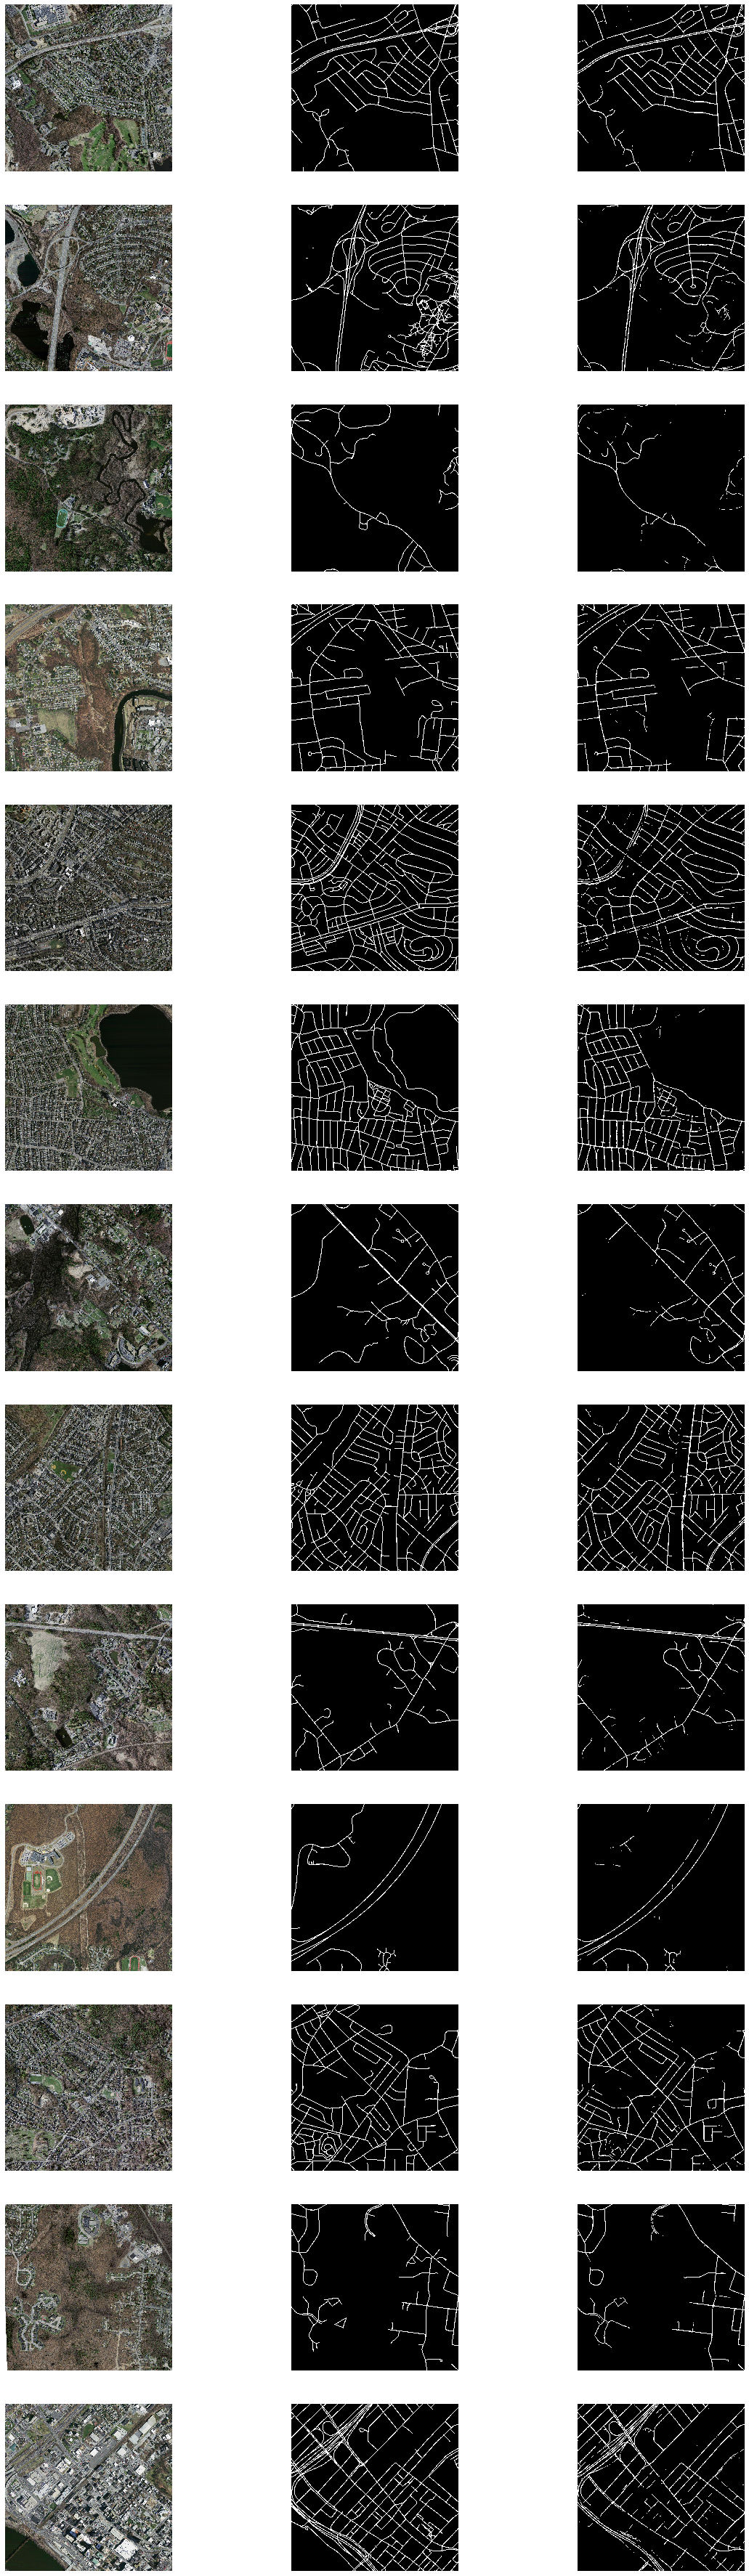

In [42]:
visualize_results()